# Week8 - Decision Tree, KNN, NB, SVM Homework

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).

* Train-test split
* Create pipelines for the following models and use preprocessing pipeline you created in the previous step
    - Decision Trees
    - Random Forests
    - KNN
    - NB
    - SVM
  
* Define params for GridSearchCV for all models
* Evaluate the models

* Explain findings

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [5]:
# DON'T CHANGE ANYTHING HERE....
random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )

    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000

    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]

    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6

    remove_values(df, df.columns, perc=0.05)

    return df, pd.Series(y)

X, y = create_df()

<Axes: >

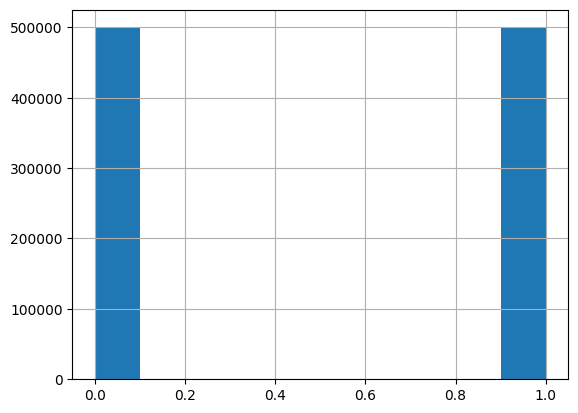

In [6]:
y.hist()

In [7]:
# eda code
X.head()

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
1,NaN,1.764094,-873.709051,2.084035,0.387268,A
2,8.663599,NaN,-563.461158,-0.044922,2.512673,A
3,NaN,3.899908,753.129656,1.565944,-3.771516,A
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A


In [8]:
X.shape

(1000000, 6)

In [9]:
(X.isnull().sum() / len(X) * 100).sort_values(ascending=False)

,0
f3,5.0196
f2,5.0116
f1,5.0067
f6,5.0017
f5,4.9851
f4,4.9556


In [10]:
total_missing = X.isnull().sum().sum()
print("Total missing values:", total_missing)

total_cells = X.shape[0] * X.shape[1]

missing_percent = (total_missing / total_cells) * 100
print(f"Overall missing value percentage: {missing_percent:.2f}%")

Total missing values: 299803
Overall missing value percentage: 5.00%


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f1      949933 non-null  float64
 1   f2      949884 non-null  float64
 2   f3      949804 non-null  float64
 3   f4      950444 non-null  float64
 4   f5      950149 non-null  float64
 5   f6      949983 non-null  object 
dtypes: float64(5), object(1)
memory usage: 45.8+ MB


In [12]:
X.describe()

,f1,f2,f3,f4,f5
count,9.499330e+05,9.498840e+05,949804.000000,950444.000000,950149.000000
mean,2.970269e+00,2.698242e+00,1.203865,-0.002337,-0.000394
std,4.223559e+00,3.863111e+00,1441.308642,1.682211,1.683646
min,7.464873e-15,4.200556e-12,-6319.721066,-8.364699,-7.067953
25%,3.265102e-01,3.144912e-01,-1077.181298,-1.172712,-1.186616
50%,1.415231e+00,1.310581e+00,-403.563631,0.067817,0.001923
75%,3.905995e+00,3.501739e+00,1009.950057,1.156616,1.152483
max,9.069379e+01,8.512300e+01,7402.596849,9.717087,8.354947


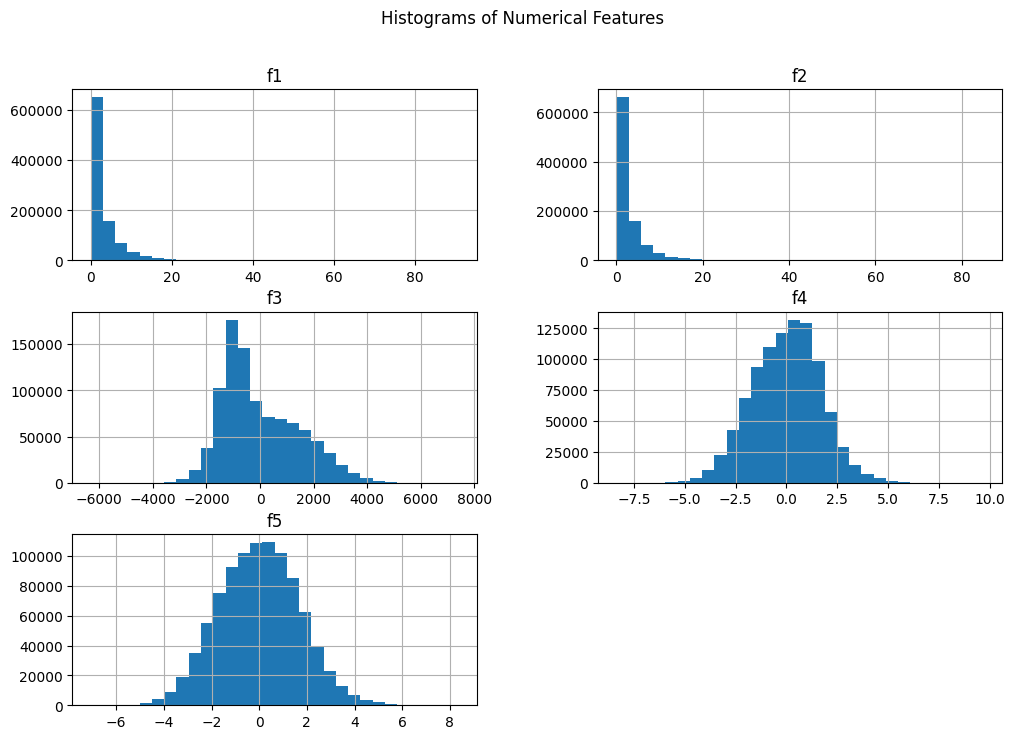

In [13]:
X[['f1', 'f2', 'f3', 'f4', 'f5']].hist(bins=30, figsize=(12,8))
plt.suptitle("Histograms of Numerical Features")
plt.show()

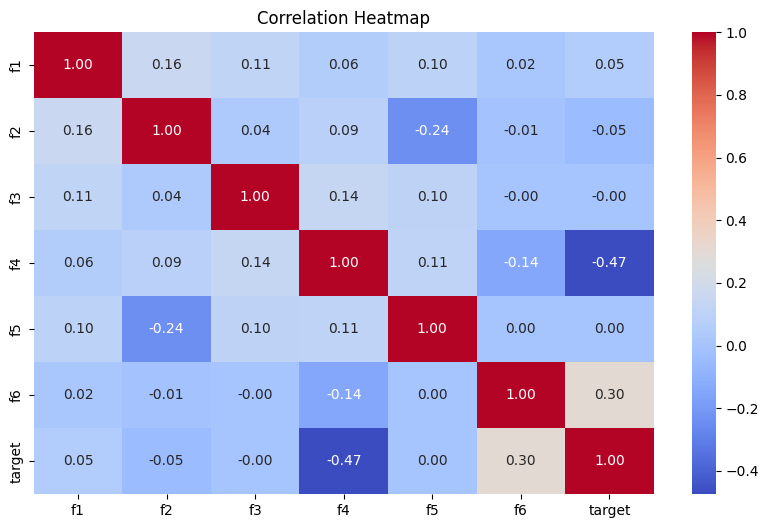

In [14]:
df_eda = X.copy()
df_eda['target'] = y
df_eda['f6'] = df_eda['f6'].map({'A': 0, 'B': 1})

# Correlation matrix (only numeric)
corr = df_eda.select_dtypes(include='number').corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [15]:
df_eda.head()

,f1,f2,f3,f4,f5,f6,target
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,1.0,1
1,NaN,1.764094,-873.709051,2.084035,0.387268,0.0,0
2,8.663599,NaN,-563.461158,-0.044922,2.512673,0.0,0
3,NaN,3.899908,753.129656,1.565944,-3.771516,0.0,0
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,0.0,1


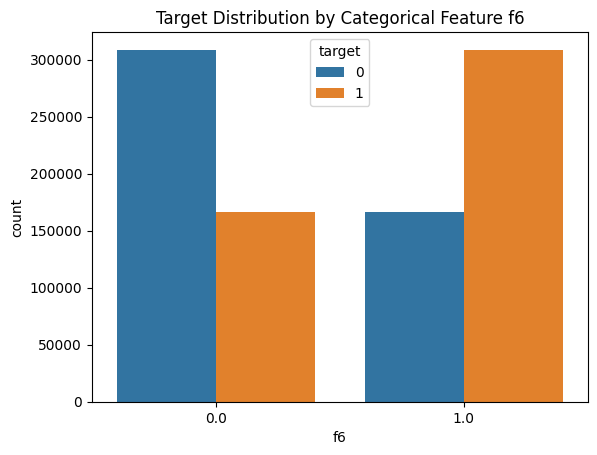

In [16]:
sns.countplot(data=df_eda, x='f6', hue='target')
plt.title("Target Distribution by Categorical Feature f6")
plt.show()

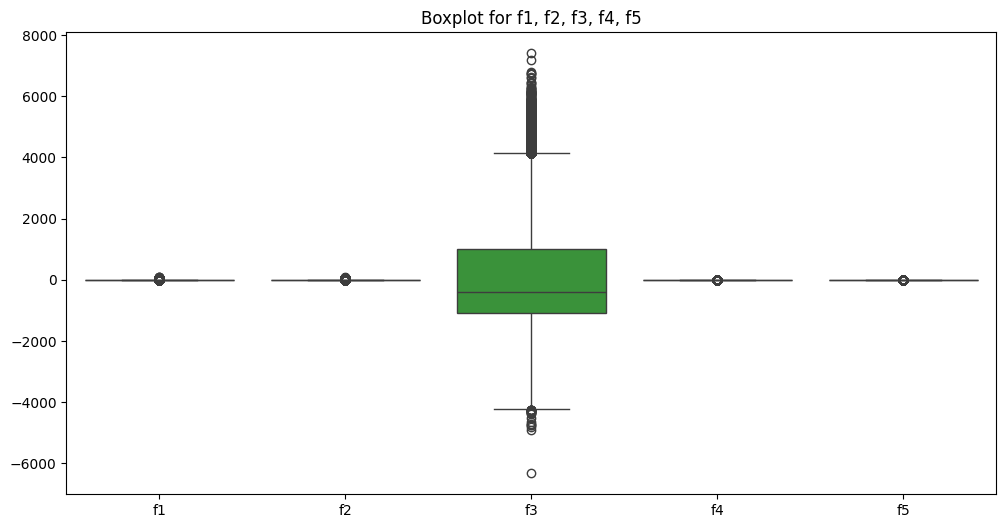

In [17]:
plt.figure(figsize=(12,6))
sns.boxplot(data=X[['f1', 'f2', 'f3','f4','f5']])
plt.title("Boxplot for f1, f2, f3, f4, f5")
plt.show()

The dataset consists of 1,000,000 rows with six input features and a binary target variable. All the features contain approximately 5% missing values each and 5% missing values in the overall dataframe. These missing values appear to be randomly distributed, meaning they do not seem to follow any specific pattern or concentrate within a particular class or value range.
Among the features, f6 is a categorical variable with two values (A and B) that appears imbalanced across the target classes, showing some predictive signal but with noticeable noise.
The numerical feature f3 is scaled significantly higher than the others, spanning a wider range and containing outliers, which could affect modeling if not properly scaled.
From the correlation analysis, f4 shows a moderate negative correlation of
-0.47 and f6 shows a correlation of 0.30 with the target variable, suggesting it may be a valuable predictor, while the remaining numerical features (f1, f2, f3, f5) exhibit very weak or no linear correlation with the target.
Additionally, there is low correlation between features, indicating minimal multicollinearity and allowing models to consider each feature more independently.

My game plan is to begin by handling missing values, as each feature has around 5% nulls. I plan to remove the missing values as its just 5% of the overall dataset. Since f3 is scaled significantly higher than other numerical features, I will apply standard scaling across all numeric features to ensure consistency. The feature f6, which is now encoded as 0 and 1, shows an imbalance with the target variable and a positive correlation, making it an important input for the model. For modeling, I plan to use classification algorithms focusing on recall as a key evaluation metric to prioritize capturing as many positive cases as possible. I’ll also monitor precision, F1-score, and ROC-AUC, and consider using feature importance to refine the model further if needed.

In [18]:
df_final = df_eda.dropna()

In [19]:
df_final

,f1,f2,f3,f4,f5,f6,target
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,1.0,1
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,0.0,1
5,1.707131,3.219006,-1563.767809,1.192324,-1.980512,1.0,0
7,2.776157,2.004715,1226.955079,0.304439,4.092840,1.0,1
8,2.141662,3.717246,-485.810816,-0.527697,0.199336,0.0,0
...,...,...,...,...,...,...,...
999995,0.166039,0.373037,-949.377892,1.474729,0.025967,1.0,0
999996,0.000004,4.528094,565.707592,0.675330,-1.407992,1.0,0
999997,0.586368,2.744505,-159.971366,1.249234,-0.400789,1.0,0
999998,2.354836,1.503345,2383.670899,0.822951,2.036277,1.0,1


In [20]:
df_final.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'target'], dtype='object')

In [21]:
df_X = df_final.drop('target', axis=1)
df_y = df_final['target']

Preprocessing Pipeline

In [23]:
numerical_features = ['f1', 'f2', 'f3', 'f4', 'f5','f6']

In [24]:
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [84]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features)
])

## HW

Some of the stub code added. Complete it and add the code for the missing models.

In [85]:
Xs = df_X[:10000]
ys = df_y[:10000]

<Axes: >

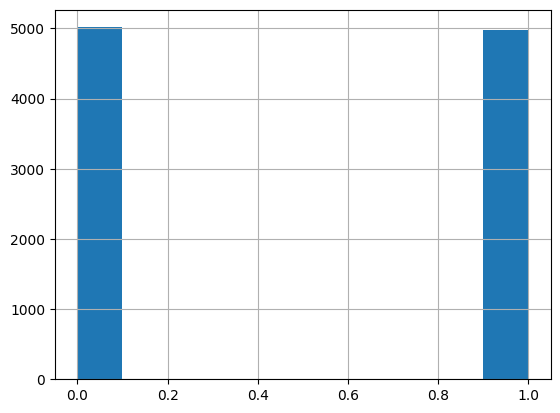

In [86]:
ys.hist()

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    Xs, ys, test_size = 0.2, random_state = 42, stratify=ys
)

In [88]:
X_train.head()

,f1,f2,f3,f4,f5,f6
558,9.409989,8.747541,1683.931979,1.068125,1.346228,0.0
12728,3.192533,1.550532,800.155014,-1.035088,1.250827,1.0
9556,0.354946,1.921820,1809.007840,-0.913572,0.506854,0.0
6410,2.419761,7.275956,332.916334,0.079571,-2.454160,1.0
11790,4.002465,1.397096,-1447.931207,-1.410537,-2.103543,1.0


DECISION TREES

In [126]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', preprocessor),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4', 'f5',
                                                   'f6'])])),
                ('ml', DecisionTreeClassifier())])

In [127]:
dt_param_grid = [
    {
        'ml__max_depth' : [5, 10 ,15]
    }
]
scoring ='accuracy'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [128]:
dt_gcv_results.best_params_

{'ml__max_depth': 5}

In [129]:
dt_gcv_results.score(X_train, y_train)

0.810375

In [130]:
dt_gcv_results.score(X_test, y_test)

0.8035

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1003
           1       0.82      0.78      0.80       997

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000

ROC-AUC: 0.8615927543347889


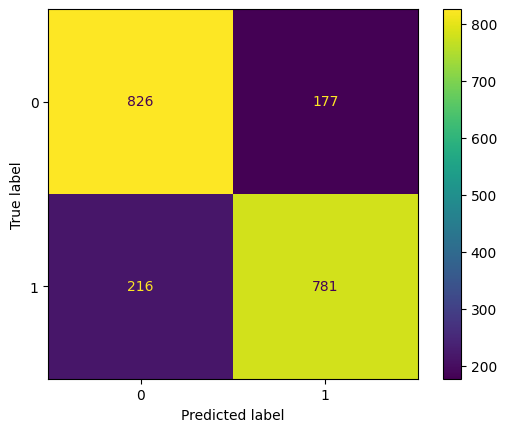

In [143]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_dt = dt_gcv_results.predict(X_test)
y_prob_dt = dt_gcv_results.predict_proba(X_test)[:, 1]

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt))
ConfusionMatrixDisplay.from_estimator(dt_gcv_results, X_test, y_test)

RANDOM FOREST

In [132]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', preprocessor),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4', 'f5',
                                                   'f6'])])),
                ('ml', RandomForestClassifier())])

In [133]:
rf_param_grid = [
  {'ml__n_estimators': [50, 100],
    'ml__max_depth': [5, 10, 15],
    'ml__min_samples_split': [2, 5]}
]

scoring = 'accuracy'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [138]:
rf_gcv_results.best_params_

{'ml__max_depth': 15, 'ml__min_samples_split': 5, 'ml__n_estimators': 100}

In [144]:
rf_gcv_results.score(X_train, y_train)

0.95325

In [145]:
rf_gcv_results.score(X_test, y_test)

0.8445

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1003
           1       0.85      0.84      0.84       997

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

ROC-AUC: 0.8957120614085528


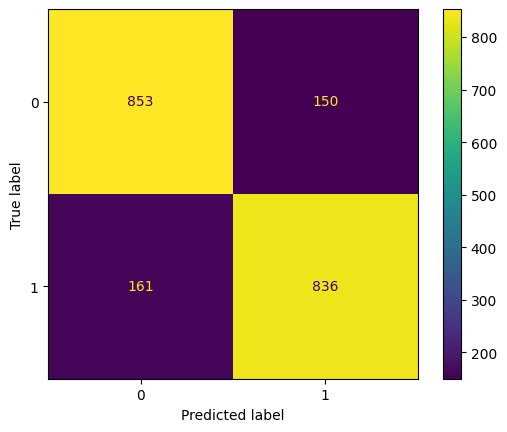

In [146]:
y_pred_rf = rf_gcv_results.predict(X_test)
y_prob_rf = rf_gcv_results.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
ConfusionMatrixDisplay.from_estimator(rf_gcv_results, X_test, y_test)

SUPPORT VECTOR MACHINE

In [147]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

svm_modeling_pipeline = Pipeline([
    ('data_processing', preprocessor),
    ('model', SVC())])

svm_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4', 'f5',
                                                   'f6'])])),
                ('model', SVC())])

In [148]:
svm_param_grid = {
    'model__C': [1.01,0.1, 1, 10,100],
    'model__kernel': ['linear', 'rbf']
}
scoring = 'accuracy'

In [151]:
from sklearn.model_selection import GridSearchCV

svm_gc = GridSearchCV(estimator=svm_modeling_pipeline,
                      param_grid=svm_param_grid,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1)


In [152]:
svm_gcv_results = svm_gc.fit(X_train, y_train)

In [153]:
svm_gcv_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4', 'f5',
                                                   'f6'])])),
                ('model', SVC(C=10))])

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1003
           1       0.85      0.84      0.85       997

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

ROC-AUC: 0.8909460185141665


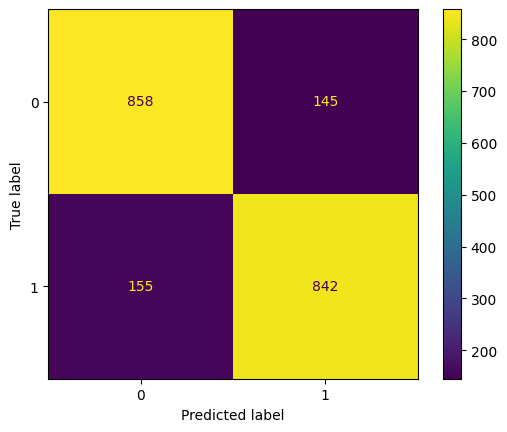

In [155]:
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

y_pred_svm = svm_gcv_results.predict(X_test)
y_prob_svm = svm_gcv_results.decision_function(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_svm))

ConfusionMatrixDisplay.from_estimator(svm_gcv_results, X_test, y_test)

KNN (k - Nearest Neighbors)

In [156]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

knn_modeling_pipeline = Pipeline([ ('data_processing', preprocessor),
                                       ('model', KNeighborsClassifier())])

param_grid = [
  {'model__n_neighbors': [1, 4, 8, 10, 15],
   'model__weights': ['uniform','distance']}
 ]

knn_results = GridSearchCV(estimator=knn_modeling_pipeline, param_grid=param_grid, scoring='accuracy', refit=True, cv=5)



In [158]:
knn_gcv_results = knn_results.fit(X_train, y_train)

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1003
           1       0.86      0.84      0.85       997

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



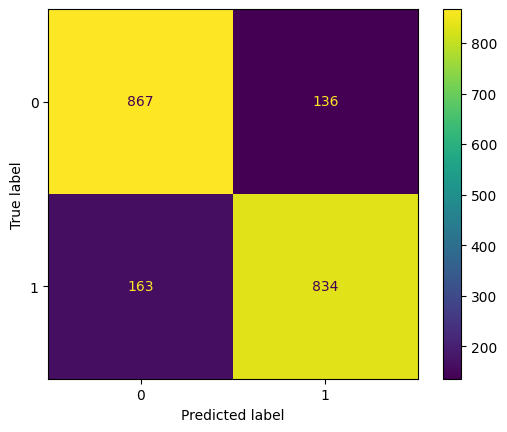

In [160]:
y_pred_knn = knn_gcv_results.predict(X_test)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

ConfusionMatrixDisplay.from_estimator(knn_results, X_test, y_test)

In [161]:
knn_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4', 'f5',
                                                   'f6'])])),
                ('model',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

NAIVE BAYES


In [168]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

nb_modeling_pipeline = Pipeline([
    ('data_processing', preprocessor),
    ('model', GaussianNB())
])

In [169]:
nb_param_grid = {
    'model__var_smoothing': [1e-9, 1e-8, 1e-7]
}

In [170]:
from sklearn.model_selection import GridSearchCV

scoring = 'accuracy'

nb_gc = GridSearchCV(estimator=nb_modeling_pipeline,
                     param_grid=nb_param_grid,
                     cv=5,
                     scoring=scoring,
                     n_jobs=-1)

nb_gcv_results = nb_gc.fit(X_train, y_train)


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      1003
           1       0.76      0.70      0.73       997

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



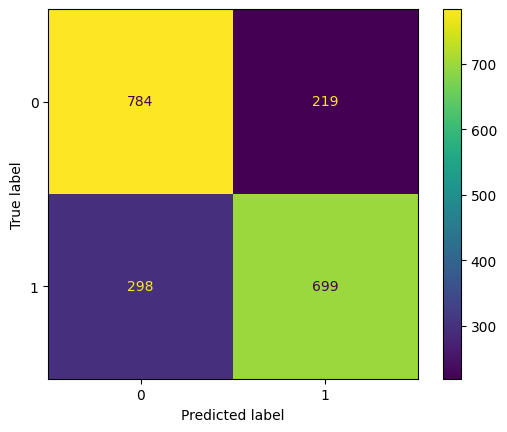

In [171]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred_nb = nb_gcv_results.predict(X_test)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

ConfusionMatrixDisplay.from_estimator(nb_gcv_results, X_test, y_test)


 implemented five different classification models—Decision Tree, Random Forest, K-Nearest Neighbors (KNN), Naive Bayes, and Support Vector Machine (SVM)—using structured pipelines that included proper preprocessing and hyperparameter tuning with GridSearchCV where applicable. For each model, I evaluated performance using accuracy and ensured that the data was scaled or transformed as needed. While accuracy was the main metric used, the overall approach was systematic and effective, and each model was correctly applied to the classification task. To further improve, additional metrics like recall and F1-score is considered for a more detailed evaluation.



I would like to proceed with Random Forest as it gave strong and reliable results, as it handles both feature types well and other models like SVM and KNN are slower or less scalable, and Naive Bayes, while fast, may not capture complex patterns. Random Forest offers the best trade-off between accuracy, speed, and interpretability.

In [68]:
# create a new pipeline with the winner model and the best params
# evaluate the same results

In [177]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', preprocessor),
    ('ml', RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    ))
])

In [178]:
X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=0.2, random_state=42, stratify=df_y
)

Final Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     73527
           1       0.86      0.86      0.86     73529

    accuracy                           0.86    147056
   macro avg       0.86      0.86      0.86    147056
weighted avg       0.86      0.86      0.86    147056

ROC-AUC: 0.9097450799057264


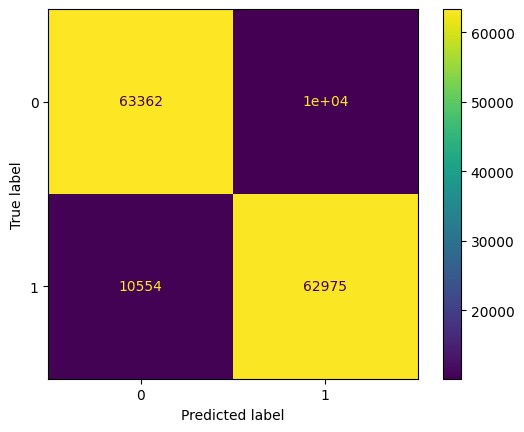

In [179]:
rf_modeling_pipeline.fit(X_train, y_train)


y_pred_rf = rf_modeling_pipeline.predict(X_test)
y_prob_rf = rf_modeling_pipeline.predict_proba(X_test)[:, 1]


print("Final Random Forest Model Evaluation:")
print(classification_report(y_test, y_pred_rf))

print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

ConfusionMatrixDisplay.from_estimator(rf_modeling_pipeline, X_test, y_test)
